# Double DK rumour spreading model


In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

class State(Enum):
    IGNORANT = 0 # People who haven't encountered the rumour
    RUMOUR_SPREADER = 1 # People actively spreading the rumour
    RUMOUR_CONTAINER = 2 # People who have heard the rumour but are not spreading it
    TRUTH_SPREADER = 3 # People actively spreading the truth
    TRUTH_CONTAINER = 4 # People who have heard the truth but are not spreading it

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLIQUISHNESS = 44

ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.4
TRUTH_ACCEPTANCE_PROB = 0.6

SPREADER_SPREADER_STIFLE_PROB = 0.1
SPREADER_STIFLER_STIFLE_PROB = 0.1

FORGET_PROB = 0.01

In [27]:
class Person:
    def __init__(self) -> None:
        self.state = State.IGNORANT
        self.contacted = []

    def spread_rumour(self, neighbour):
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                neighbour.state = State.RUMOUR_SPREADER
        # If neighbour is a spreader
        elif neighbour.state == State.RUMOUR_SPREADER:
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.RUMOUR_CONTAINER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.RUMOUR_CONTAINER
        # If neighbour is a stifler
        elif neighbour.state == State.RUMOUR_CONTAINER:
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.RUMOUR_CONTAINER
        # If neighbour knows the truth
        elif neighbour.state == State.TRUTH_SPREADER or neighbour.state == State.TRUTH_CONTAINER:
            if np.random.random() < TRUTH_ACCEPTANCE_PROB:
                self.state = State.TRUTH_SPREADER

    def spread_truth(self, neighbour):
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            if np.random.random() < TRUTH_ACCEPTANCE_PROB:
                neighbour.state = State.TRUTH_SPREADER
        # If neighbour is a spreader
        elif neighbour.state == State.TRUTH_SPREADER:
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.TRUTH_CONTAINER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.TRUTH_CONTAINER
        # If neighbour is a stifler
        elif neighbour.state == State.TRUTH_CONTAINER:
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.TRUTH_CONTAINER
        # If neighbour knows the rumour
        elif neighbour.state == State.RUMOUR_SPREADER or neighbour.state == State.RUMOUR_CONTAINER:
            if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                self.state = State.RUMOUR_SPREADER

    def next(self):
        if np.random.random() < FORGET_PROB:
            self.state = State.IGNORANT

        self.contacted = []

    def set_state(self, state):
        self.state = state

In [28]:
class DKModel:
    def __init__(self, graph, initial_rumour_spreaders: int, initial_truth_spreaders: int) -> None:
        self.graph = graph

        for node in range(POPULATION_SIZE):
            graph.nodes[node]['agent'] = Person()

        # TODO: make sure the starters are not the same
        rumour_starters = np.random.choice(graph.nodes, initial_rumour_spreaders, replace=False)
        for node in rumour_starters:
            graph.nodes[node]['agent'].set_state(State.RUMOUR_SPREADER)

        truth_starters = np.random.choice(graph.nodes, initial_truth_spreaders, replace=False)
        for node in truth_starters:
            graph.nodes[node]['agent'].set_state(State.TRUTH_SPREADER)

        # History tracking
        self.i_history = []
        self.rs_history = []
        self.rc_history = []
        self.ts_history = []
        self.tc_history = []

    def step(self) -> None:
        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']

            for neighbour in self.graph.neighbors(node):
                if not agent.state in [State.TRUTH_SPREADER, State.RUMOUR_SPREADER]:
                    break

                if agent.state == State.RUMOUR_SPREADER:
                    agent.spread_rumour(self.graph.nodes[neighbour]['agent'])
                elif agent.state == State.TRUTH_SPREADER:
                    agent.spread_truth(self.graph.nodes[neighbour]['agent'])

        # Count states
        ignorants, rumour_spreaders, rumour_containers, truth_spreaders, truth_containers = self.count_states()

        self.i_history.append(ignorants)
        self.rs_history.append(rumour_spreaders)
        self.rc_history.append(rumour_containers)
        self.ts_history.append(truth_spreaders)
        self.tc_history.append(truth_containers)

        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']
            agent.next()

    def count_states(self):
        ignorants, rumour_spreaders, rumour_containers, truth_spreaders, truth_containers = 0, 0, 0, 0, 0
        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']
            if agent.state == State.IGNORANT:
                ignorants += 1
            elif agent.state == State.RUMOUR_SPREADER:
                rumour_spreaders += 1
            elif agent.state == State.RUMOUR_CONTAINER:
                rumour_containers += 1
            elif agent.state == State.TRUTH_SPREADER:
                truth_spreaders += 1
            elif agent.state == State.TRUTH_CONTAINER:
                truth_containers += 1
        return ignorants, rumour_spreaders, rumour_containers, truth_spreaders, truth_containers

    def draw(self) -> None:
        plt.figure(figsize=(10, 6))

        # Assemble colour map
        colours = []
        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']
            if agent.state == State.IGNORANT:
                colours.append('red')
            elif agent.state == State.RUMOUR_SPREADER:
                colours.append('blue')
            elif agent.state == State.RUMOUR_CONTAINER:
                colours.append('green')
            elif agent.state == State.TRUTH_SPREADER:
                colours.append('purple')
            elif agent.state == State.TRUTH_CONTAINER:
                colours.append('yellow')

        nx.draw(self.graph, node_size=50, node_color=colours, with_labels=False)
        plt.title('DK Model of Rumor Propagation on a Graph')
        plt.show()

    def run(self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
        if draw:
            self.draw()

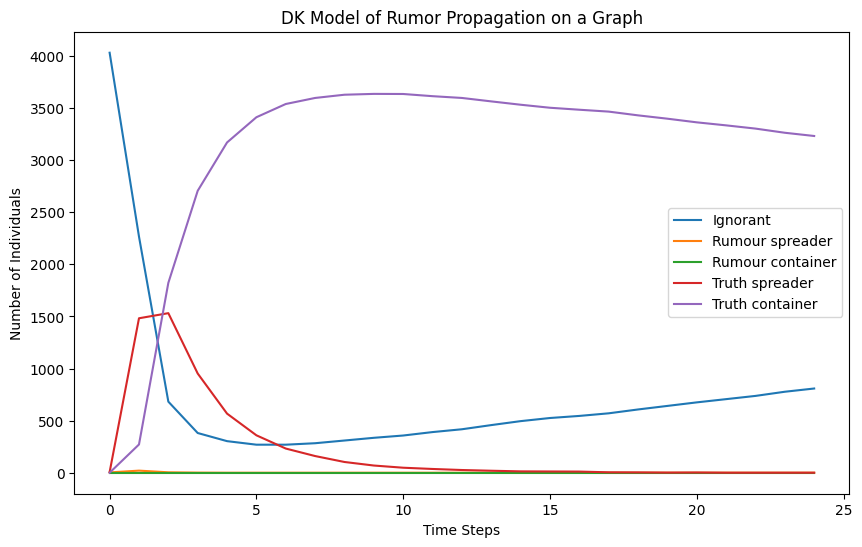

In [38]:
graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
dk_model = DKModel(graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
dk_model.run(TIME_STEPS, draw=False)

plt.figure(figsize=(10, 6))
plt.plot(dk_model.i_history, label='Ignorant')
plt.plot(dk_model.rs_history, label='Rumour spreader')
plt.plot(dk_model.rc_history, label='Rumour container')
plt.plot(dk_model.ts_history, label='Truth spreader')
plt.plot(dk_model.tc_history, label='Truth container')
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

